# 03 — Demographic Analysis

NB02 showed this is a corporate-led, high-concentration product (Accounts = 77.6% of tickets, top 10 = 42%, repeat rate 94.1%). Since Accounts have no meaningful age/gender, the demographic focus here is on individuals (the growth segment), geography across all customers, and how demographics interact with the behavioural patterns from NB02.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 120

ticket_sales = pd.read_csv('../data/raw/ticket_sales.csv')
customers = pd.read_csv('../data/raw/customers.csv')

# same cleaning as NB01
ticket_sales['event_date'] = pd.to_datetime(ticket_sales['event_date'], errors='coerce')
ticket_sales['transaction_date'] = pd.to_datetime(ticket_sales['transaction_date'], errors='coerce')
customers = customers.copy()
customers['is_england_customer'] = customers['district'].notna()

print(f'Tickets:   {len(ticket_sales):,}')
print(f'Customers: {len(customers):,}')
print('Customer types:', customers['customer_type'].value_counts().to_dict())

Tickets:   43,289
Customers: 277
Customer types: {'Customer': 202, 'Account': 75}


In [2]:
# master dataset
df = ticket_sales.merge(
    customers,
    left_on='purchaser_id',
    right_on='customer_id',
    how='left',
    suffixes=('', '_purchaser')
)

df['is_self_purchase'] = df['purchaser_id'] == df['owner_id']

total_tickets = len(df)
unique_purchasers = df['purchaser_id'].nunique()
account_ticket_share = (df['customer_type'].eq('Account').mean() * 100)

print(f'Total tickets: {total_tickets:,}')
print(f'Unique purchasers: {unique_purchasers:,}')
print(f'Account ticket share: {account_ticket_share:.1f}%')

Total tickets: 43,289
Unique purchasers: 256
Account ticket share: 77.6%


## Individual customer demographics

Accounts don't have age/gender so all demographic profiling focuses on `customer_type == 'Customer'`.

In [3]:
# Filter to individual customers
individuals = customers[customers['customer_type'] == 'Customer'].copy()

print(f'Individual customers: {len(individuals):,}')
print('Missing age:', individuals['age'].isna().sum())
print('Missing gender:', individuals['gender'].isna().sum())
print('Country distribution (top):')
print(individuals['country'].value_counts(dropna=False).head(10).to_string())

Individual customers: 202
Missing age: 34
Missing gender: 0
Country distribution (top):
country
England           178
NaN                12
United Kingdom      9
Australia           2
Israel              1


### Age distribution

In [4]:
age_series = individuals['age'].dropna()
print(f'Age stats (individuals, n={len(age_series):,} / {len(individuals):,})')
print(f'  mean={age_series.mean():.1f}, median={age_series.median():.1f}, range={age_series.min():.0f}-{age_series.max():.0f}')

Age stats (individuals, n=168 / 202)
  mean=57.2, median=58.5, range=18-92


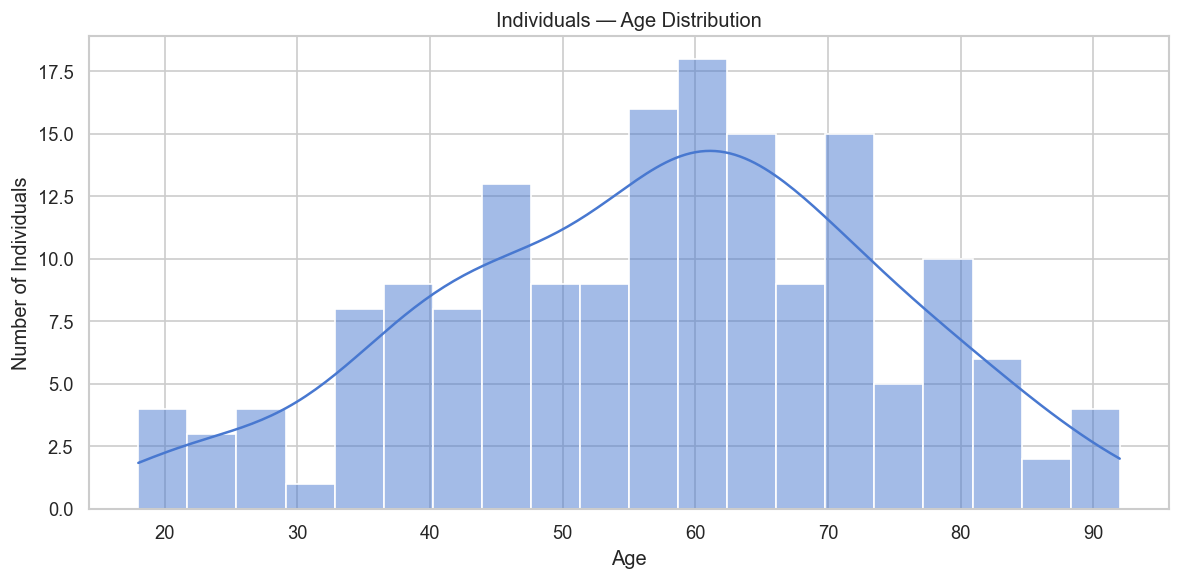

In [5]:
# Visual: age histogram
plt.figure(figsize=(10, 5))
sns.histplot(age_series, bins=20, kde=True)
plt.title('Individuals — Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Individuals')
plt.tight_layout()
plt.savefig('../data/charts/nb03_individual_age_distribution.png', bbox_inches='tight')
plt.show()

In [6]:
# age buckets
bins = [0, 17, 29, 39, 49, 59, 120]
labels = ['<18', '18–29', '30–39', '40–49', '50–59', '60+']
individuals['age_bucket'] = pd.cut(individuals['age'], bins=bins, labels=labels, right=True)
bucket_counts = individuals['age_bucket'].value_counts(dropna=False).reindex(labels)
bucket_pct = (bucket_counts / bucket_counts.sum() * 100).round(1)

age_bucket_df = pd.DataFrame({'count': bucket_counts, 'pct': bucket_pct})
print('Age buckets (non-missing):')
display(age_bucket_df)

Age buckets (non-missing):


,count,pct
age_bucket,,
<18,0,0.0
18–29,11,6.5
30–39,14,8.3
40–49,29,17.3
50–59,35,20.8
60+,79,47.0


### Defining high-value individuals
Using top 25% by ticket volume as the cutoff — adapts to the dataset's skew rather than picking an arbitrary threshold.

In [7]:
# Individual engagement: tickets per individual purchaser (ticket volume proxy)
ind_ticket_volume = (
    df[df['customer_type'] == 'Customer']
    .groupby('purchaser_id')
    .size()
    .reset_index(name='ticket_count')
)

# Attach individual demographics
ind_profile = ind_ticket_volume.merge(
    individuals,
    left_on='purchaser_id',
    right_on='customer_id',
    how='left'
)

# Define top quartile cutoff
cutoff = ind_profile['ticket_count'].quantile(0.75)
ind_profile['value_segment'] = np.where(ind_profile['ticket_count'] > cutoff, 'High-value (top 25%)', 'Lower-value (bottom 75%)')

print(f'Individuals with ticket volume records: {len(ind_profile):,}')
print(f'Top 25% cutoff (tickets): > {cutoff:.0f}')
print(ind_profile['value_segment'].value_counts().to_string())

Individuals with ticket volume records: 181
Top 25% cutoff (tickets): > 50
value_segment
Lower-value (bottom 75%)    136
High-value (top 25%)         45


### Age vs engagement

Age by value segment:


,count,mean,median
value_segment,,,
High-value (top 25%),41,59.6,59.0
Lower-value (bottom 75%),112,56.2,58.5


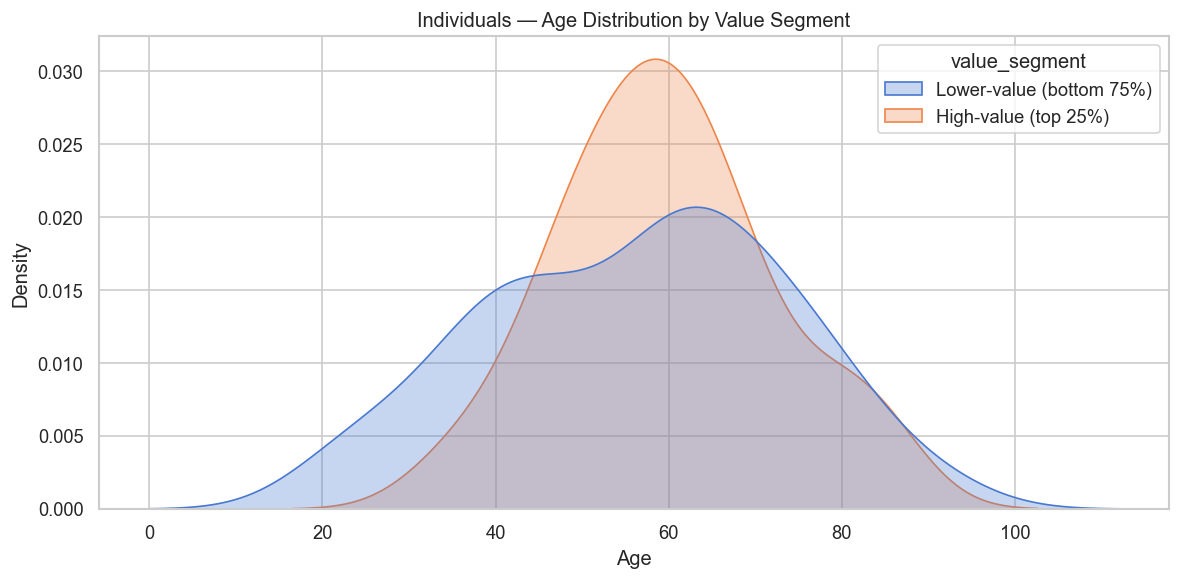

In [8]:
# age by value segment
seg_age = ind_profile.dropna(subset=['age']).copy()

summary = (
    seg_age.groupby('value_segment')['age']
    .agg(['count', 'mean', 'median'])
    .round(1)
)
print('Age by value segment:')
display(summary)

plt.figure(figsize=(10, 5))
sns.kdeplot(data=seg_age, x='age', hue='value_segment', common_norm=False, fill=True, alpha=0.3)
plt.title('Individuals — Age Distribution by Value Segment')
plt.xlabel('Age')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('../data/charts/nb03_age_by_value_segment.png', bbox_inches='tight')
plt.show()

### Gender distribution
Worth checking whether gender skews and whether it matters for engagement. 'Unspecified' values mean we should be cautious here.

Gender (individuals):


,count,pct
gender,,
Male,145,71.8
Unspecified,38,18.8
Female,19,9.4


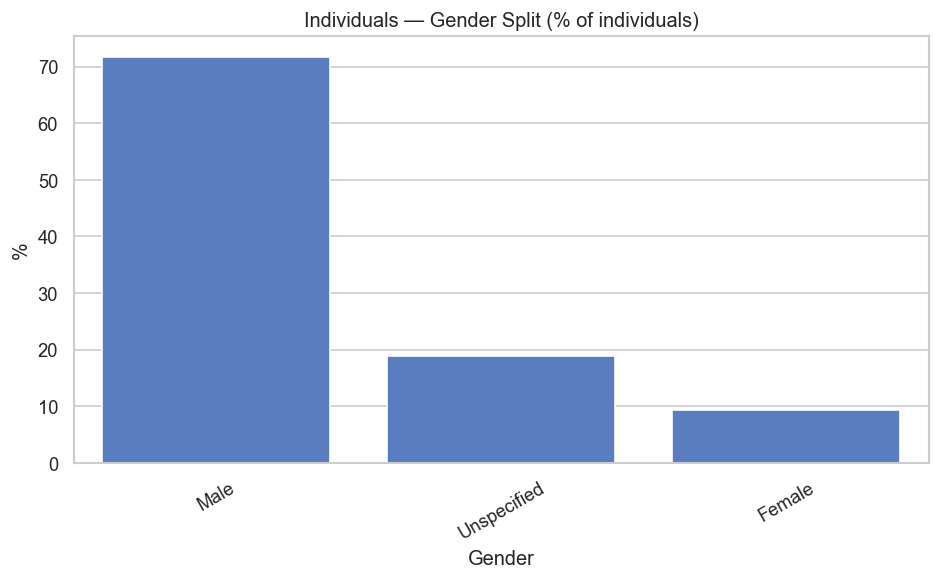

In [9]:
# gender split
gender_counts = individuals['gender'].value_counts(dropna=False)
gender_pct = (gender_counts / gender_counts.sum() * 100).round(1)
gender_df = pd.DataFrame({'count': gender_counts, 'pct': gender_pct})
print('Gender (individuals):')
display(gender_df)

plt.figure(figsize=(8, 5))
sns.barplot(x=gender_df.index.astype(str), y=gender_df['pct'].values)
plt.title('Individuals — Gender Split (% of individuals)')
plt.xlabel('Gender')
plt.ylabel('%')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('../data/charts/nb03_individual_gender_split.png', bbox_inches='tight')
plt.show()

Gender by value segment:


,value_segment,gender,count,pct_within_segment
1,High-value (top 25%),Male,33,73.3
0,High-value (top 25%),Female,8,17.8
2,High-value (top 25%),Unspecified,4,8.9
4,Lower-value (bottom 75%),Male,102,75.0
5,Lower-value (bottom 75%),Unspecified,28,20.6
3,Lower-value (bottom 75%),Female,6,4.4


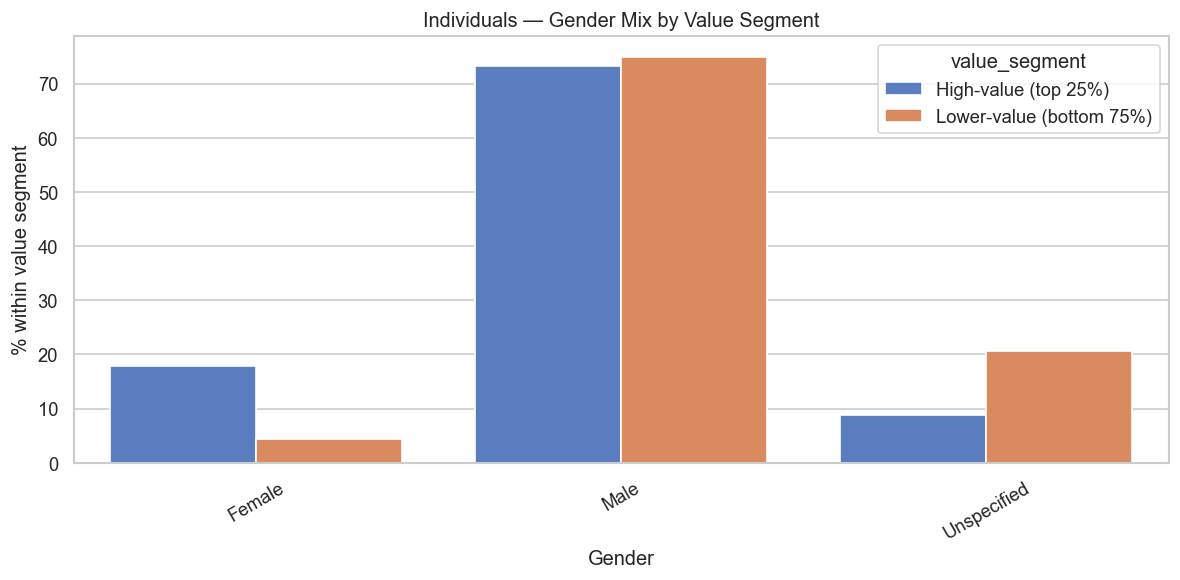

In [10]:
# gender vs value segment
seg_gender = ind_profile.dropna(subset=['gender']).copy()
gender_value = (
    seg_gender.groupby(['value_segment', 'gender'])
    .size()
    .reset_index(name='count')
)
gender_value['pct_within_segment'] = (gender_value['count'] / gender_value.groupby('value_segment')['count'].transform('sum') * 100).round(1)

print('Gender by value segment:')
display(gender_value.sort_values(['value_segment','count'], ascending=[True, False]))

plt.figure(figsize=(10, 5))
sns.barplot(data=gender_value, x='gender', y='pct_within_segment', hue='value_segment')
plt.title('Individuals — Gender Mix by Value Segment')
plt.xlabel('Gender')
plt.ylabel('% within value segment')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('../data/charts/nb03_gender_by_value_segment.png', bbox_inches='tight')
plt.show()

## Geographic analysis (all customers)
Using `is_england_customer` so we don't accidentally drop non-England folks. England-specific fields like district and distance only apply where relevant.

England vs non-England:


,segment,tickets,pct_tickets,purchasers,avg_tickets_per_purchaser
0,Non-England,797,1.8,25,31.9
1,England,42492,98.2,231,183.9


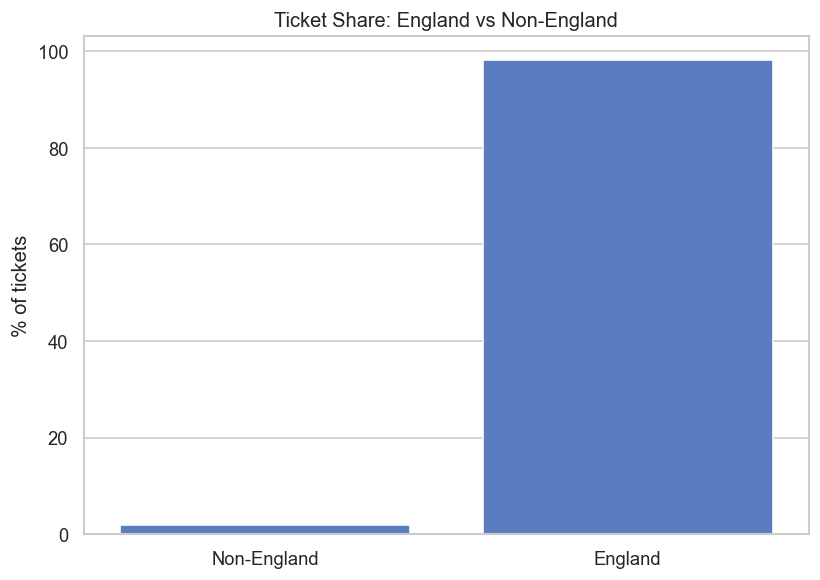

In [11]:
# england vs non-england ticket share
geo_ticket = (
    df.groupby('is_england_customer')
      .agg(
          tickets=('transaction_id', 'count'),
          purchasers=('purchaser_id', 'nunique')
      )
      .reset_index()
)
geo_ticket['pct_tickets'] = (geo_ticket['tickets'] / total_tickets * 100).round(1)
geo_ticket['avg_tickets_per_purchaser'] = (geo_ticket['tickets'] / geo_ticket['purchasers']).round(1)
geo_ticket['segment'] = np.where(geo_ticket['is_england_customer'], 'England', 'Non-England')

print('England vs non-England:')
display(geo_ticket[['segment','tickets','pct_tickets','purchasers','avg_tickets_per_purchaser']])

plt.figure(figsize=(7,5))
sns.barplot(data=geo_ticket, x='segment', y='pct_tickets')
plt.title('Ticket Share: England vs Non-England')
plt.xlabel('')
plt.ylabel('% of tickets')
plt.tight_layout()
plt.savefig('../data/charts/nb03_england_vs_nonengland_ticket_share.png', bbox_inches='tight')
plt.show()

In [12]:
# repeat rate by geography
purch_geo = (
    df.groupby('purchaser_id')
      .agg(
          transaction_count=('transaction_id', 'nunique'),
          is_england=('is_england_customer', 'max')
      )
      .reset_index()
)
purch_geo['is_repeat'] = purch_geo['transaction_count'] > 1
repeat_geo = purch_geo.groupby('is_england')['is_repeat'].mean().reset_index()
repeat_geo['repeat_rate_pct'] = (repeat_geo['is_repeat'] * 100).round(1)
repeat_geo['segment'] = np.where(repeat_geo['is_england'], 'England', 'Non-England')

print('Repeat rate by geography:')
display(repeat_geo[['segment','repeat_rate_pct']])

Repeat rate by geography:


,segment,repeat_rate_pct
0,Non-England,92.0
1,England,94.4


### Distance to Bramall Lane (England only)
Checking whether local fans drive hospitality or if long-distance travellers punch above their weight.

Distance buckets (England purchasers):


,distance_bucket,purchasers,avg_tickets,repeat_rate_pct
0,0-10 km,114,218.4,96.5
1,10-25 km,80,189.0,95.0
2,25-50 km,7,70.1,100.0
3,50+ km,30,66.0,83.3


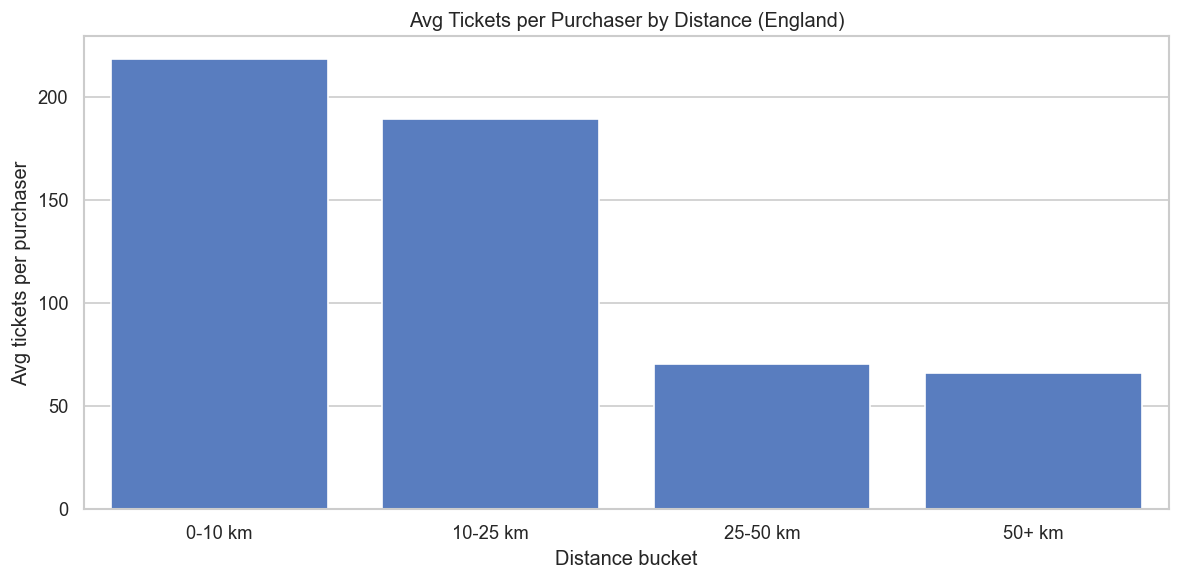

In [13]:
# distance buckets (england only)
england = customers[customers['is_england_customer']].copy()

purch_tickets = df.groupby('purchaser_id').size().reset_index(name='ticket_count')
purch_txn = df.groupby('purchaser_id')['transaction_id'].nunique().reset_index(name='transaction_count')
purch_profile = purch_tickets.merge(purch_txn, on='purchaser_id', how='left')
purch_profile = purch_profile.merge(customers, left_on='purchaser_id', right_on='customer_id', how='left')
purch_profile['is_repeat'] = purch_profile['transaction_count'] > 1

eng_purch = purch_profile[purch_profile['is_england_customer']].copy()

dist_bins = [0, 10, 25, 50, 99999]
dist_labels = ['0-10 km', '10-25 km', '25-50 km', '50+ km']
eng_purch['distance_bucket'] = pd.cut(eng_purch['distance_to_bramall_lane_km'], bins=dist_bins, labels=dist_labels, right=True)

dist_summary = (
    eng_purch.groupby('distance_bucket', observed=True)
      .agg(
          purchasers=('purchaser_id', 'nunique'),
          avg_tickets=('ticket_count', 'mean'),
          repeat_rate=('is_repeat', 'mean')
      )
      .reset_index()
)
dist_summary['avg_tickets'] = dist_summary['avg_tickets'].round(1)
dist_summary['repeat_rate_pct'] = (dist_summary['repeat_rate'] * 100).round(1)

print('Distance buckets (England purchasers):')
display(dist_summary[['distance_bucket','purchasers','avg_tickets','repeat_rate_pct']])

plt.figure(figsize=(10,5))
sns.barplot(data=dist_summary, x='distance_bucket', y='avg_tickets')
plt.title('Avg Tickets per Purchaser by Distance (England)')
plt.xlabel('Distance bucket')
plt.ylabel('Avg tickets per purchaser')
plt.tight_layout()
plt.savefig('../data/charts/nb03_avg_tickets_by_distance.png', bbox_inches='tight')
plt.show()

## Demographics x behaviour interaction
The key question here isn't just "who are these customers" but "does who they are predict how they spend?"

Age-ticket correlation: 0.123


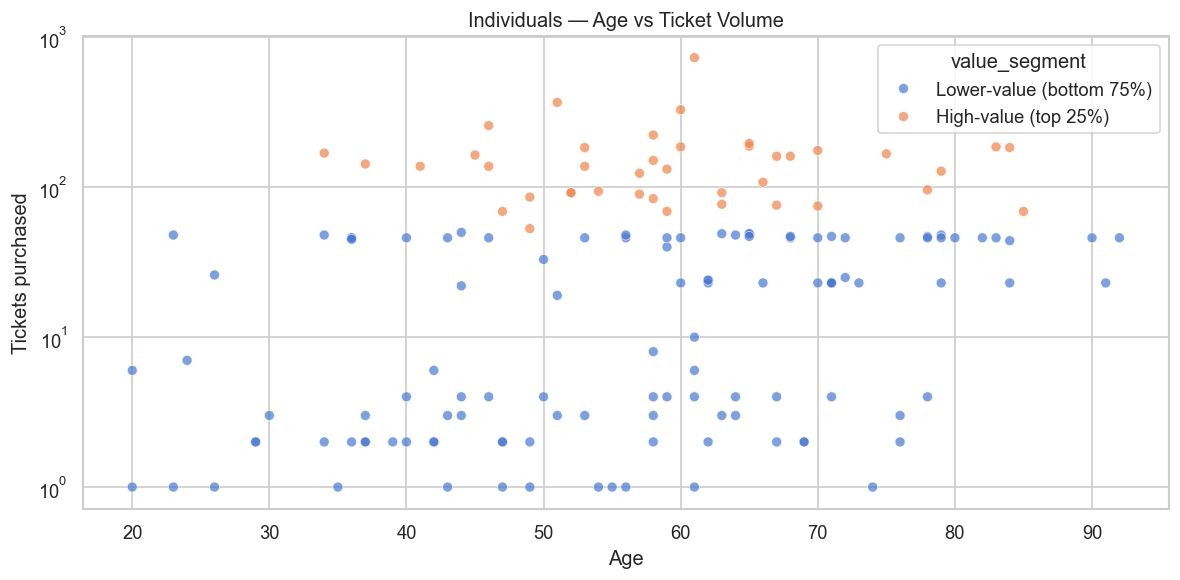

In [14]:
# age vs ticket volume
age_volume = ind_profile.dropna(subset=['age']).copy()
corr = age_volume['age'].corr(age_volume['ticket_count'])
print(f'Age-ticket correlation: {corr:.3f}')

plt.figure(figsize=(10,5))
sns.scatterplot(data=age_volume, x='age', y='ticket_count', hue='value_segment', alpha=0.7)
plt.title('Individuals — Age vs Ticket Volume')
plt.xlabel('Age')
plt.ylabel('Tickets purchased')
plt.yscale('log')
plt.tight_layout()
plt.savefig('../data/charts/nb03_age_vs_ticket_volume.png', bbox_inches='tight')
plt.show()

Age bucket engagement:


,age_bucket,count,mean,median
0,18–29,9,10.4,2.0
1,30–39,14,36.7,3.0
2,40–49,27,42.8,4.0
3,50–59,31,69.5,46.0
4,60+,72,66.6,46.0


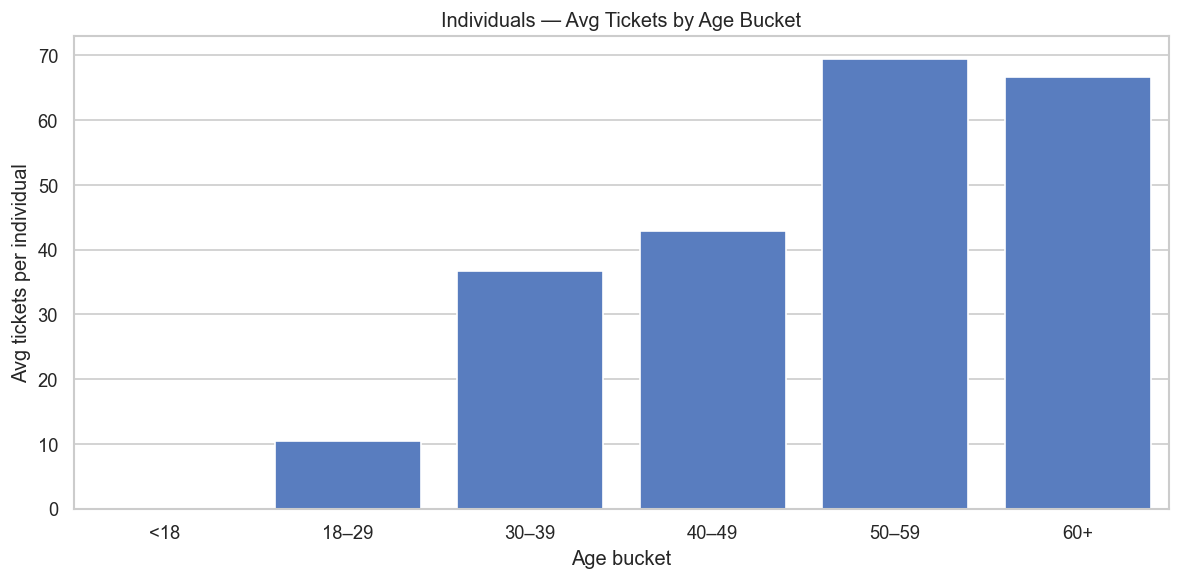

In [15]:
# age bucket vs avg tickets
age_volume['age_bucket'] = pd.cut(age_volume['age'], bins=bins, labels=labels, right=True)
bucket_engagement = (
    age_volume.groupby('age_bucket', observed=True)['ticket_count']
      .agg(['count','mean','median'])
      .round(1)
      .reset_index()
)
print('Age bucket engagement:')
display(bucket_engagement)

plt.figure(figsize=(10,5))
sns.barplot(data=bucket_engagement, x='age_bucket', y='mean')
plt.title('Individuals — Avg Tickets by Age Bucket')
plt.xlabel('Age bucket')
plt.ylabel('Avg tickets per individual')
plt.tight_layout()
plt.savefig('../data/charts/nb03_avg_tickets_by_age_bucket.png', bbox_inches='tight')
plt.show()

Distance-ticket correlation (England): -0.109


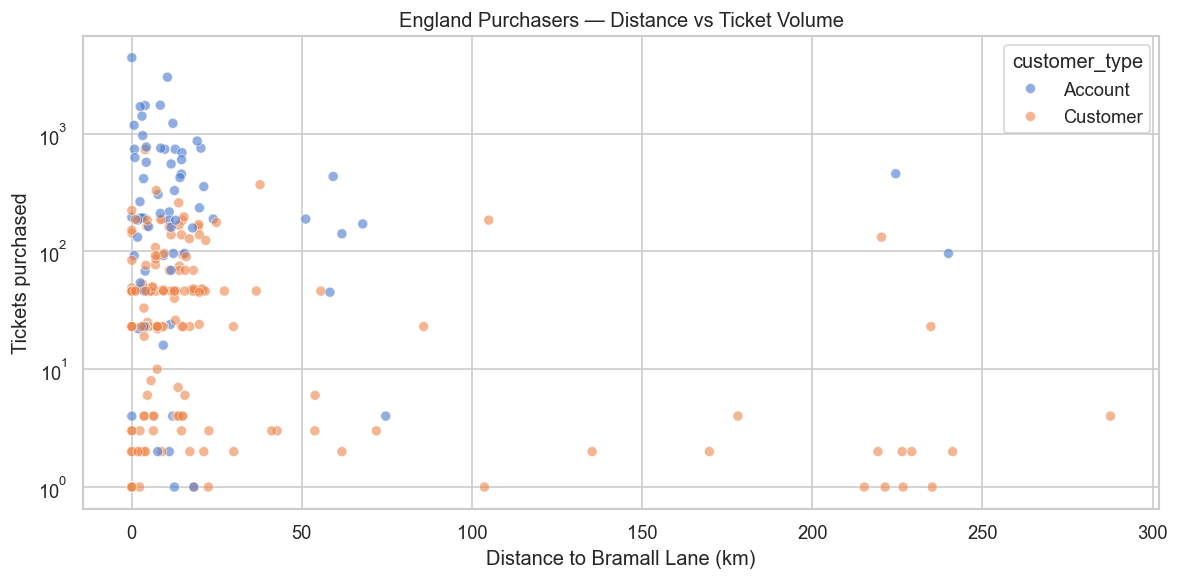

In [16]:
# distance vs engagement (england)
eng_for_corr = eng_purch.dropna(subset=['distance_to_bramall_lane_km']).copy()
dist_corr = eng_for_corr['distance_to_bramall_lane_km'].corr(eng_for_corr['ticket_count'])
print(f'Distance-ticket correlation (England): {dist_corr:.3f}')

plt.figure(figsize=(10,5))
sns.scatterplot(data=eng_for_corr, x='distance_to_bramall_lane_km', y='ticket_count', hue='customer_type', alpha=0.6)
plt.title('England Purchasers — Distance vs Ticket Volume')
plt.xlabel('Distance to Bramall Lane (km)')
plt.ylabel('Tickets purchased')
plt.yscale('log')
plt.tight_layout()
plt.savefig('../data/charts/nb03_distance_vs_ticket_volume.png', bbox_inches='tight')
plt.show()

In [17]:
# england vs non-england engagement
geo_engagement = (
    purch_profile.groupby('is_england_customer')
      .agg(
          purchasers=('purchaser_id', 'nunique'),
          avg_tickets=('ticket_count', 'mean'),
          repeat_rate=('is_repeat', 'mean')
      )
      .reset_index()
)
geo_engagement['segment'] = np.where(geo_engagement['is_england_customer'], 'England', 'Non-England')
geo_engagement['avg_tickets'] = geo_engagement['avg_tickets'].round(1)
geo_engagement['repeat_rate_pct'] = (geo_engagement['repeat_rate'] * 100).round(1)

print('Engagement by geography:')
display(geo_engagement[['segment','purchasers','avg_tickets','repeat_rate_pct']])

Engagement by geography:


,segment,purchasers,avg_tickets,repeat_rate_pct
0,Non-England,25,31.9,92.0
1,England,231,183.9,94.4


## High-value individual profiling
Comparing the top 25% by ticket volume against the rest — what does a high-value hospitality individual actually look like?

High vs low value profile:


,Segment,Individuals,Avg tickets,Median tickets,Avg age (non-missing),England %,Avg distance km (England only)
0,High-value (top 25%),45,154.2,138.0,59.6,93.3,18.5
1,Lower-value (bottom 75%),136,20.2,16.0,56.2,86.8,36.4


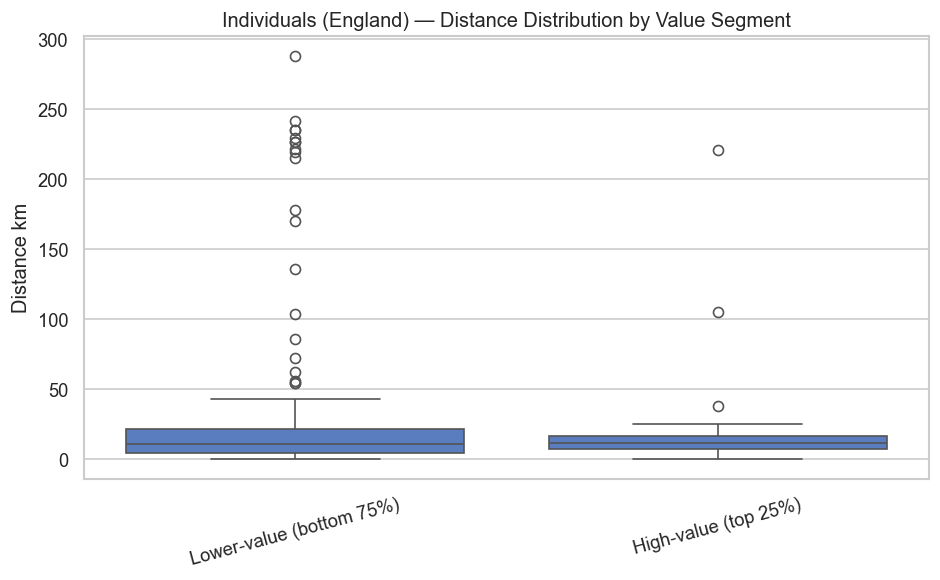

In [18]:
# profile: high vs low value individuals
profile_fields = ['age', 'gender', 'is_england_customer', 'distance_to_bramall_lane_km']
seg = ind_profile.copy()

profile_summary = []
for segment in ['High-value (top 25%)', 'Lower-value (bottom 75%)']:
    s = seg[seg['value_segment'] == segment]
    profile_summary.append({
        'Segment': segment,
        'Individuals': len(s),
        'Avg tickets': round(s['ticket_count'].mean(), 1),
        'Median tickets': round(s['ticket_count'].median(), 1),
        'Avg age (non-missing)': round(s['age'].dropna().mean(), 1),
        'England %': round((s['is_england_customer'].mean() * 100), 1),
        'Avg distance km (England only)': round(s[s['is_england_customer']]['distance_to_bramall_lane_km'].dropna().mean(), 1)
    })

profile_summary_df = pd.DataFrame(profile_summary)
print('High vs low value profile:')
display(profile_summary_df)

# distance by value segment (england only)
dist_seg = seg[seg['is_england_customer']].dropna(subset=['distance_to_bramall_lane_km']).copy()
plt.figure(figsize=(8,5))
sns.boxplot(data=dist_seg, x='value_segment', y='distance_to_bramall_lane_km')
plt.title('Individuals (England) — Distance Distribution by Value Segment')
plt.xlabel('')
plt.ylabel('Distance km')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('../data/charts/nb03_distance_by_value_segment.png', bbox_inches='tight')
plt.show()

## Corporate accounts
No age or gender here, but geography still tells us something — are these local Sheffield businesses or spread across the country?

Account geography:


,segment,accounts,pct
0,Non-England,4,5.3
1,England,71,94.7



England accounts with distance: 71 / 75


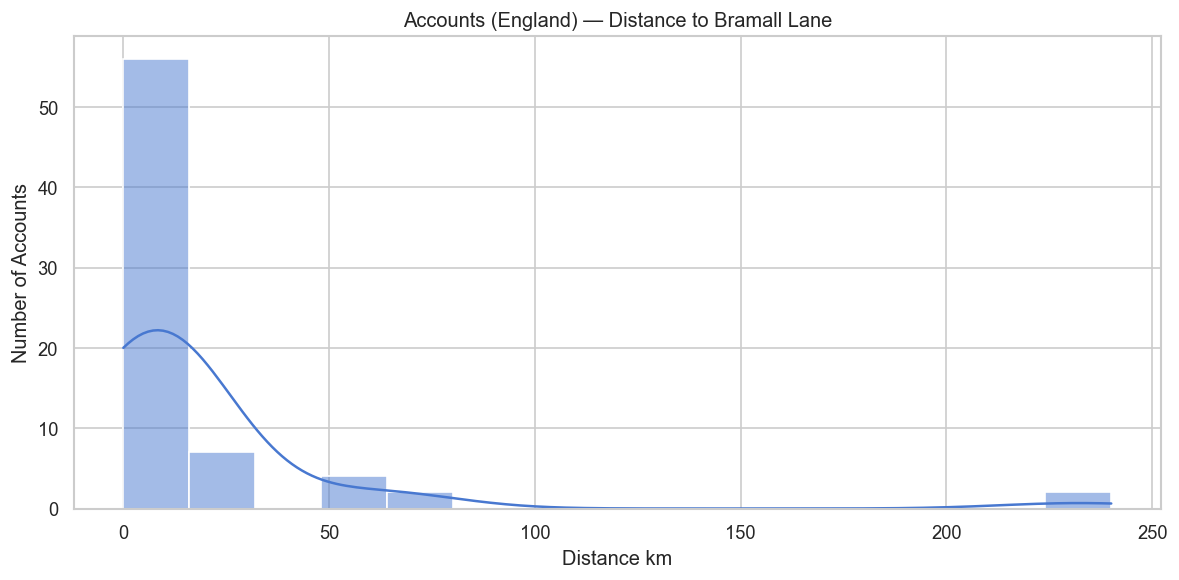

In [19]:
# account geography
accounts = customers[customers['customer_type'] == 'Account'].copy()

acc_geo = (
    accounts.groupby('is_england_customer')
      .size()
      .reset_index(name='accounts')
)
acc_geo['segment'] = np.where(acc_geo['is_england_customer'], 'England', 'Non-England')
acc_geo['pct'] = (acc_geo['accounts'] / acc_geo['accounts'].sum() * 100).round(1)

print('Account geography:')
display(acc_geo[['segment','accounts','pct']])

# distance for england accounts
acc_eng = accounts[accounts['is_england_customer']].dropna(subset=['distance_to_bramall_lane_km']).copy()
print(f'\nEngland accounts with distance: {len(acc_eng):,} / {len(accounts):,}')

plt.figure(figsize=(10,5))
sns.histplot(acc_eng['distance_to_bramall_lane_km'], bins=15, kde=True)
plt.title('Accounts (England) — Distance to Bramall Lane')
plt.xlabel('Distance km')
plt.ylabel('Number of Accounts')
plt.tight_layout()
plt.savefig('../data/charts/nb03_account_distance_distribution.png', bbox_inches='tight')
plt.show()

## Segmentation framing (before clustering)
Translating what we've seen so far into rough customer segments. These are hypotheses — would need revenue/pricing data to properly validate.

### Proposed segments

1. **Corporate season holders** — accounts with multi-seat season allocations, the revenue backbone
2. **Local repeat individuals** — older, nearby, high-volume buyers
3. **Occasional buyers** — match-by-match, likely younger, lower volume
4. **Long-distance travellers** — 50+ km or non-England, surprisingly committed

Strategically: segment 1 is about retention, segments 2-4 are where growth and diversification come from.

## Demographic summary
Pulling it all together — what does the demographic picture tell us for strategy?

In [20]:
# demographic summary (data-driven, updates with the dataset)
ind_age_non_missing = individuals['age'].dropna()
ind_age_mean = ind_age_non_missing.mean() if len(ind_age_non_missing) else np.nan
ind_age_median = ind_age_non_missing.median() if len(ind_age_non_missing) else np.nan

eng_ticket_share = geo_ticket.loc[geo_ticket['segment']=='England','pct_tickets'].values
noneng_ticket_share = geo_ticket.loc[geo_ticket['segment']=='Non-England','pct_tickets'].values
eng_ticket_share = eng_ticket_share[0] if len(eng_ticket_share) else np.nan
noneng_ticket_share = noneng_ticket_share[0] if len(noneng_ticket_share) else np.nan

print('-' * 40)
print('Demographic summary')
print('-' * 40)
print(f'''
Individuals make up ~{100 - account_ticket_share:.1f}% of ticket volume (accounts dominate the rest).
Age (non-missing): mean {ind_age_mean:.1f}, median {ind_age_median:.1f}.
High-value cutoff: top 25% by volume (> {cutoff:.0f} tickets).

Geography: England {eng_ticket_share:.1f}% of tickets, non-England {noneng_ticket_share:.1f}%.

Takeaways:
- Retain corporate accounts (stability) while growing individual base (diversification)
- Distance buckets help target local professionals vs long-distance committed travellers
- Better guest-level data from corporate bookings would unlock real demographic insights
''')

----------------------------------------
Demographic summary
----------------------------------------

Individuals make up ~22.4% of ticket volume (accounts dominate the rest).
Age (non-missing): mean 57.2, median 58.5.
High-value cutoff: top 25% by volume (> 50 tickets).

Geography: England 98.2% of tickets, non-England 1.8%.

Takeaways:
- Retain corporate accounts (stability) while growing individual base (diversification)
- Distance buckets help target local professionals vs long-distance committed travellers
- Better guest-level data from corporate bookings would unlock real demographic insights



## Demographic x behaviour clustering (individuals only)

Accounts don't have age/gender so we're clustering individuals only.

Features: age (median-imputed where missing), distance to Bramall Lane (non-England gets max + 50 as a proxy), log-transformed ticket volume, and transaction count. Running KMeans with k=3 since we want segments that are actually actionable rather than statistically optimal.

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# build individual feature table from ind_profile
clust_df = ind_profile.copy()

# impute missing age with median
age_median = clust_df['age'].median()
clust_df['age_imputed'] = clust_df['age'].fillna(age_median)

# non-england distance: use max observed + 50 km as "far away" proxy
max_dist = clust_df['distance_to_bramall_lane_km'].max()
clust_df['distance_imputed'] = clust_df['distance_to_bramall_lane_km'].fillna(max_dist + 50)

# transaction count
ind_txn = (
    df[df['customer_type'] == 'Customer']
    .groupby('purchaser_id')['transaction_id']
    .nunique()
    .reset_index(name='transaction_count')
)
clust_df = clust_df.merge(ind_txn, on='purchaser_id', how='left')
clust_df['transaction_count'] = clust_df['transaction_count'].fillna(1)

clust_df['log_tickets'] = np.log1p(clust_df['ticket_count'])

feature_cols = ['age_imputed', 'distance_imputed', 'log_tickets', 'transaction_count']
X_ind = clust_df[feature_cols].values

scaler = StandardScaler()
X_ind_scaled = scaler.fit_transform(X_ind)

print(f'Individuals for clustering: {len(clust_df):,}')
print(f'Features: {feature_cols}')
print(f'Age imputed (median): {age_median:.0f}, distance imputed (non-England): {max_dist + 50:.0f} km')

Individuals for clustering: 181
Features: ['age_imputed', 'distance_imputed', 'log_tickets', 'transaction_count']
Age imputed (median): 59, distance imputed (non-England): 338 km


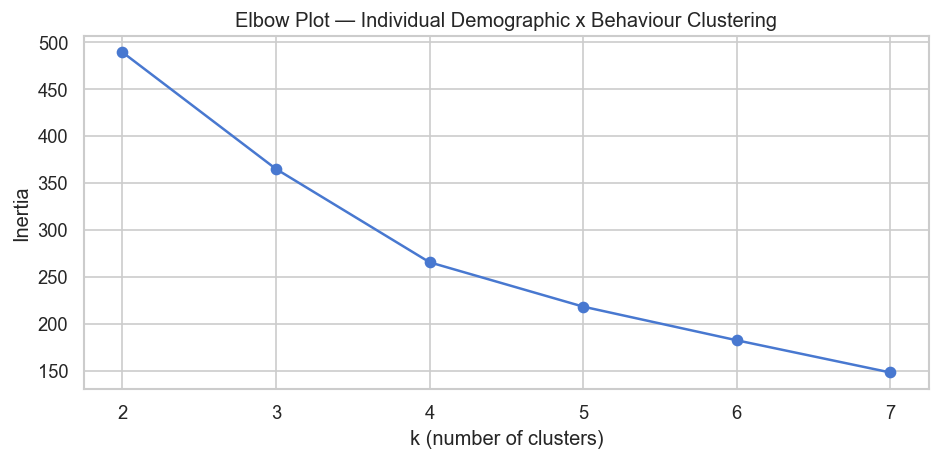

k=3 looks like the sweet spot here.


In [22]:
# elbow check
inertias = []
K_range = range(2, 8)
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_ind_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(list(K_range), inertias, 'o-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Inertia')
plt.title('Elbow Plot — Individual Demographic x Behaviour Clustering')
plt.tight_layout()
plt.savefig('../data/charts/nb03_elbow_plot_individuals.png', bbox_inches='tight')
plt.show()
print('k=3 looks like the sweet spot here.')

In [23]:
# fit k=3 and profile
km3 = KMeans(n_clusters=3, n_init=10, random_state=42)
clust_df['cluster'] = km3.fit_predict(X_ind_scaled)

ind_cluster_profile = (
    clust_df.groupby('cluster')
    .agg(
        n_individuals=('purchaser_id', 'count'),
        avg_age=('age_imputed', 'mean'),
        avg_distance_km=('distance_imputed', 'mean'),
        avg_tickets=('ticket_count', 'mean'),
        avg_transactions=('transaction_count', 'mean'),
        pct_england=('is_england_customer', lambda x: x.mean() * 100),
        pct_male=('gender', lambda x: (x == 'Male').mean() * 100)
    )
    .round(1)
    .reset_index()
)
ind_cluster_profile['ticket_share_pct'] = (
    clust_df.groupby('cluster')['ticket_count'].sum().values /
    clust_df['ticket_count'].sum() * 100
).round(1)

print('Cluster profiles (k=3):')
display(ind_cluster_profile)

Cluster profiles (k=3):


,cluster,n_individuals,avg_age,avg_distance_km,avg_tickets,avg_transactions,pct_england,pct_male,ticket_share_pct
0,0,69,49.3,18.2,13.3,13.3,100.0,75.4,9.5
1,1,80,64.9,16.3,102.0,102.0,100.0,81.2,84.2
2,2,32,55.9,300.2,19.2,19.2,34.4,56.2,6.3


Individual segments (labelled):


,segment_label,individuals,avg_age,avg_distance_km,avg_tickets,pct_england,pct_male,ticket_share_pct
0,High-Value Local Regulars,80,64.9,16.3,102.0,100.0,81.2,84.2
1,Mid-Engagement Steady Fans,32,55.9,300.2,19.2,34.4,56.2,6.3
2,Low-Volume Occasionals,69,49.3,18.2,13.3,100.0,75.4,9.5


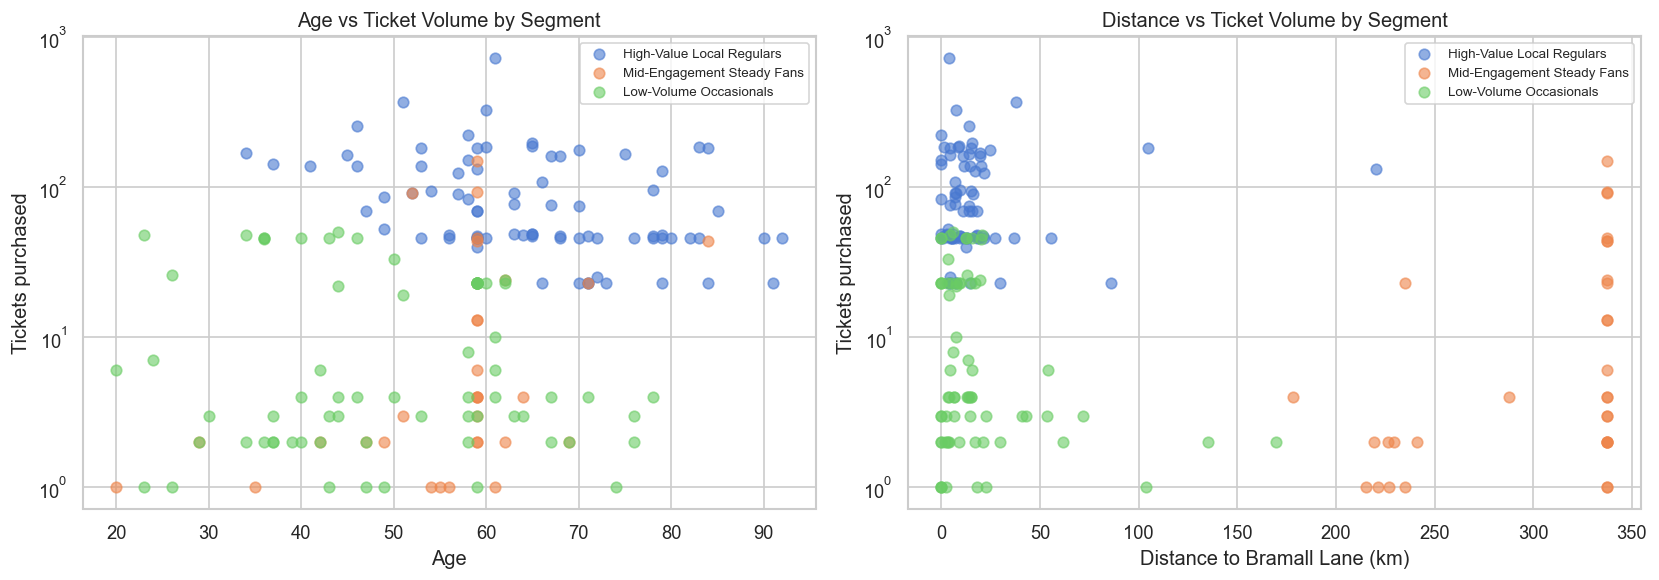

In [24]:
# label clusters and visualise
label_order = ind_cluster_profile.sort_values('avg_tickets', ascending=False)['cluster'].tolist()
ind_label_names = [
    'High-Value Local Regulars',
    'Mid-Engagement Steady Fans',
    'Low-Volume Occasionals'
]
ind_label_map = dict(zip(label_order, ind_label_names))
clust_df['segment_label'] = clust_df['cluster'].map(ind_label_map)

ind_seg_summary = (
    clust_df.groupby('segment_label')
    .agg(
        individuals=('purchaser_id', 'count'),
        avg_age=('age_imputed', 'mean'),
        avg_distance_km=('distance_imputed', 'mean'),
        avg_tickets=('ticket_count', 'mean'),
        pct_england=('is_england_customer', lambda x: x.mean() * 100),
        pct_male=('gender', lambda x: (x == 'Male').mean() * 100)
    )
    .round(1)
    .sort_values('avg_tickets', ascending=False)
    .reset_index()
)
ind_seg_summary['ticket_share_pct'] = (
    clust_df.groupby('segment_label')['ticket_count'].sum().reindex(ind_seg_summary['segment_label']).values /
    clust_df['ticket_count'].sum() * 100
).round(1)

print('Individual segments (labelled):')
display(ind_seg_summary)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for label in ind_label_names:
    subset = clust_df[clust_df['segment_label'] == label]
    axes[0].scatter(subset['age_imputed'], subset['ticket_count'], label=label, alpha=0.6, s=40)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Tickets purchased')
axes[0].set_yscale('log')
axes[0].set_title('Age vs Ticket Volume by Segment')
axes[0].legend(fontsize=8)

for label in ind_label_names:
    subset = clust_df[clust_df['segment_label'] == label]
    axes[1].scatter(subset['distance_imputed'], subset['ticket_count'], label=label, alpha=0.6, s=40)
axes[1].set_xlabel('Distance to Bramall Lane (km)')
axes[1].set_ylabel('Tickets purchased')
axes[1].set_yscale('log')
axes[1].set_title('Distance vs Ticket Volume by Segment')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.savefig('../data/charts/nb03_individual_segments_scatter.png', bbox_inches='tight')
plt.show()